
>>> INITIALIZING SYSTEM FOR: INTC <<<

=== 1. TRAINING SPECIALIST AGENTS ===
>> Training Trend Agent (Striker)...


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_3747/567953330.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_3747/567953330.py:66: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)


>> Training Mean Rev Agent (Midfielder)...
>> Training Crisis Agent (Goalkeeper)...


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_3747/567953330.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_3747/567953330.py:66: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_3747/567953330.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_3747/567953330.py:66: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipy

=== TRAINING COMPLETE ===

=== 2. RUNNING ENSEMBLE BACKTEST (2017-09-01 to 2021-12-01) ===


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_3747/567953330.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_3747/567953330.py:66: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)


Date         | Regime     | Active Agent | VIX    | ADX    | Raw Act  | Scale Act  | Balance   
---------------------------------------------------------------------------------------------------------
2017-10-02   | TREND      | trend      | -0.14  | 60.79  | -0.02    | -0.11      | 99710     
2017-10-16   | TREND      | trend      | -0.13  | 66.78  | 0.08     | 0.41       | 99621     
2017-10-30   | TREND      | trend      | -0.13  | 62.34  | 0.18     | 0.91       | 105241    
2017-11-13   | TREND      | trend      | -0.09  | 72.91  | 0.17     | 0.83       | 106029    
2017-11-28   | TREND      | trend      | -0.13  | 49.49  | 0.27     | 1.33       | 104552    
2017-12-12   | TREND      | trend      | -0.14  | 57.22  | 0.06     | 0.30       | 100530    
2017-12-27   | TREND      | trend      | -0.12  | 41.13  | -0.01    | -0.03      | 101774    
2018-01-11   | TREND      | trend      | -0.13  | 35.06  | 0.10     | 0.49       | 98783     
2018-01-26   | TREND      | trend      | -0.09

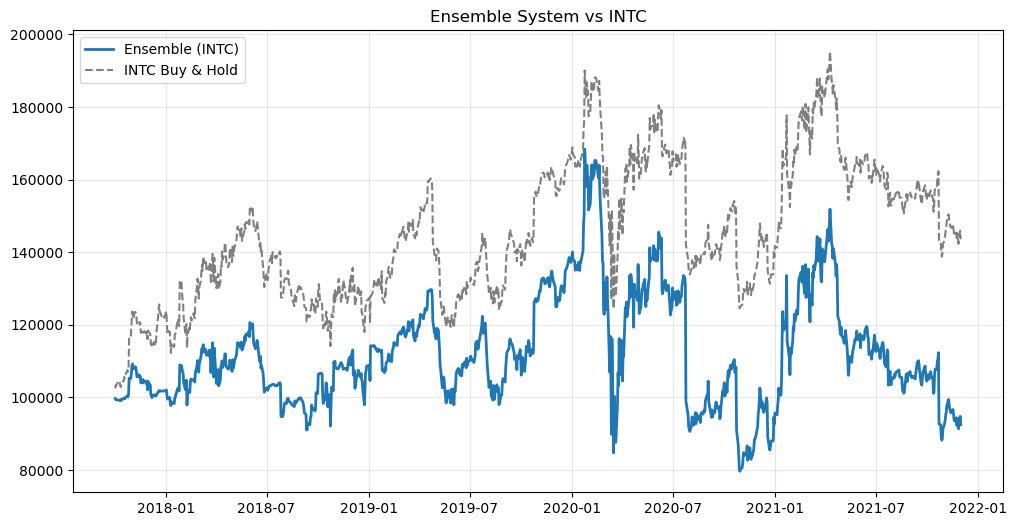

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt

# ==========================================
# 1. GLOBAL CONFIGURATION
# ==========================================
CONFIG = {
    # Assets
    "TICKERS": ["SPY", "IWM", "^VIX", "SHY"], 
    "TARGET_ASSET": "SPY",
    
    # Dates
    "TRAIN_START": "2015-01-01",
    "TRAIN_END": "2023-12-31",
    "TEST_START": "2024-01-02",
    "TEST_END": "2025-01-01",
    
    # Crisis Training Periods
    "CRISIS_PERIODS": [
        ("2007-08-01", "2009-06-01"), # GFC
        ("2018-10-01", "2019-01-01"), # Volmageddon
        ("2020-01-01", "2020-05-01"), # COVID
        ("2022-01-01", "2022-12-31"), # Bear
    ],
    
    # Feature Engineering
    "WINDOW_SIZE": 20,
    "BB_STD": 2.0,
    
    # Agent Parameters
    "LEARNING_RATE": 3e-4,
    "BATCH_SIZE": 64,
    "TRAINING_STEPS": 30000, 
    "INITIAL_BALANCE": 100000,
    "FEES": 0.0005,
    "BORROW_RATE": 0.0002, # Daily cost of leverage/shorting (approx 5% annual)
    
    # CRITICAL FIX: Leverage & Scaler
    "ACTION_SCALER": 5.0,
    "MAX_LEVERAGE": 1.5  # Allow up to 150% Long
}

# ==========================================
# 2. DATA PROCESSOR (MULTI-REGIME)
# ==========================================
class DataProcessor:
    def __init__(self, tickers):
        self.tickers = tickers
        
    def download(self, start, end):
        try:
            data = yf.download(self.tickers, start=start, end=end, progress=False)
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]: data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]: data = data.xs('Adj Close', level=0, axis=1)
            if isinstance(data, pd.Series): data = data.to_frame()
            
            # Need High/Low for ADX (Using Target Asset)
            ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)
            return data, ohlc
        except:
            return pd.DataFrame(), pd.DataFrame()

    def add_features(self, df, ohlc, target=None):
        # FIX: Ensure target uses the LATEST config value if not provided
        if target is None:
            target = CONFIG['TARGET_ASSET']
            
        df = df.copy()
        
        # --- 1. Base Returns ---
        df['returns'] = df[target].pct_change()
        
        # --- 2. Trend Indicators (ADX) ---
        df['tr'] = np.maximum(ohlc['High'] - ohlc['Low'], 
                   np.maximum(abs(ohlc['High'] - ohlc['Close'].shift(1)), 
                              abs(ohlc['Low'] - ohlc['Close'].shift(1))))
        df['dm_plus'] = np.where((ohlc['High'] - ohlc['High'].shift(1)) > (ohlc['Low'].shift(1) - ohlc['Low']), 
                                 np.maximum(ohlc['High'] - ohlc['High'].shift(1), 0), 0)
        df['dm_minus'] = np.where((ohlc['Low'].shift(1) - ohlc['Low']) > (ohlc['High'] - ohlc['High'].shift(1)), 
                                  np.maximum(ohlc['Low'].shift(1) - ohlc['Low'], 0), 0)
        
        window = 14
        df['tr_s'] = df['tr'].rolling(window).mean()
        df['dp_s'] = df['dm_plus'].rolling(window).mean()
        df['dm_s'] = df['dm_minus'].rolling(window).mean()
        
        df['di_plus'] = 100 * (df['dp_s'] / df['tr_s'])
        df['di_minus'] = 100 * (df['dm_s'] / df['tr_s'])
        df['dx'] = 100 * abs(df['di_plus'] - df['di_minus']) / (df['di_plus'] + df['di_minus'])
        df['adx'] = df['dx'].rolling(window).mean()
        
        # --- 3. Mean Reversion Indicators (Bollinger) ---
        sma = df[target].rolling(20).mean()
        std = df[target].rolling(20).std()
        df['bb_width'] = (std * 2 * 2) / sma
        df['pct_b'] = (df[target] - (sma - 2*std)) / (4*std)
        df['rsi'] = 100 - (100 / (1 + df['returns'].rolling(14).mean()/df['returns'].rolling(14).std())) # Approx RSI
        
        # --- 4. Crisis Indicators (VIX, SMA Distance) ---
        if '^VIX' in df.columns:
            df['vix_norm'] = (df['^VIX'] - 15) / 40
        else:
            df['vix_norm'] = 0
            
        sma200 = df[target].rolling(200).mean()
        df['dist_sma200'] = (df[target] - sma200) / sma200
        
        df = df.fillna(0)
        return df

    def get_data(self, start, end):
        df, ohlc = self.download(start, end)
        if df.empty: return pd.DataFrame()
        return self.add_features(df, ohlc)

    def get_crisis_data(self):
        # Stitch periods
        dfs = []
        for s, e in CONFIG['CRISIS_PERIODS']:
            d, o = self.download(s, e)
            if not d.empty:
                dfs.append(self.add_features(d, o))
        return pd.concat(dfs).reset_index(drop=True).fillna(0)

# ==========================================
# 3. UNIFIED AGENT ENVIRONMENT
# ==========================================
class TradingEnv(gym.Env):
    def __init__(self, df, mode='trend'):
        super(TradingEnv, self).__init__()
        self.df = df
        self.mode = mode # 'trend', 'mean_rev', 'crisis'
        self.n_features = df.shape[1]
        self.window = CONFIG['WINDOW_SIZE']
        self.current_step = self.window
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window * self.n_features,), dtype=np.float32)
        
        self.data = df.values.astype(np.float32)
        
    def reset(self, seed=None, options=None):
        self.current_step = self.window
        return self._get_obs(), {}
    
    def _get_obs(self):
        return self.data[self.current_step-self.window : self.current_step].flatten()

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, False, {}
            
        act = np.clip(action[0], -1, 1)
        
        # Ret Col extraction logic
        ret = self.data[self.current_step, 0] 
        
        reward = 0
        
        # --- REWARD SHAPING PER SPECIALIST ---
        if self.mode == 'trend':
            # Reward Excess Return
            reward = act * ret * 100
        elif self.mode == 'mean_rev':
            # Reward PnL but punish holding
            reward = (act * ret * 100) - (0.1 * abs(act))
        elif self.mode == 'crisis':
            # Reward Shorting in Drawdowns
            reward = (act * ret * 100)
            if ret < -0.01 and act < -0.5: reward *= 2.0 # Bonus for catching crash
            
        self.current_step += 1
        return self._get_obs(), reward, False, False, {}

# ==========================================
# 4. ENSEMBLE MANAGER
# ==========================================
class EnsembleManager:
    def __init__(self):
        self.dp = DataProcessor(CONFIG['TICKERS'])
        self.agents = {}
        self.envs = {}
        
    def train_specialists(self):
        print("\n=== 1. TRAINING SPECIALIST AGENTS ===")
        
        # 1. Trend Agent (Bull Market Data)
        print(">> Training Trend Agent (Striker)...")
        trend_data = self.dp.get_data(CONFIG['TRAIN_START'], CONFIG['TRAIN_END'])
        env_trend = DummyVecEnv([lambda: TradingEnv(trend_data, mode='trend')])
        env_trend = VecNormalize(env_trend, norm_obs=True, norm_reward=False)
        model_trend = PPO("MlpPolicy", env_trend, verbose=0, learning_rate=CONFIG['LEARNING_RATE'])
        model_trend.learn(total_timesteps=CONFIG['TRAINING_STEPS'])
        self.agents['trend'] = model_trend
        self.envs['trend'] = env_trend # Store for normalization stats
        
        # 2. Mean Reversion Agent (Chop Data)
        print(">> Training Mean Rev Agent (Midfielder)...")
        env_mr = DummyVecEnv([lambda: TradingEnv(trend_data, mode='mean_rev')]) 
        env_mr = VecNormalize(env_mr, norm_obs=True, norm_reward=False)
        model_mr = PPO("MlpPolicy", env_mr, verbose=0, learning_rate=CONFIG['LEARNING_RATE'])
        model_mr.learn(total_timesteps=CONFIG['TRAINING_STEPS'])
        self.agents['mean_rev'] = model_mr
        self.envs['mean_rev'] = env_mr
        
        # 3. Crisis Agent (Crash Data)
        print(">> Training Crisis Agent (Goalkeeper)...")
        crash_data = self.dp.get_crisis_data()
        env_crisis = DummyVecEnv([lambda: TradingEnv(crash_data, mode='crisis')])
        env_crisis = VecNormalize(env_crisis, norm_obs=True, norm_reward=False)
        model_crisis = PPO("MlpPolicy", env_crisis, verbose=0, learning_rate=CONFIG['LEARNING_RATE'])
        model_crisis.learn(total_timesteps=CONFIG['TRAINING_STEPS'])
        self.agents['crisis'] = model_crisis
        self.envs['crisis'] = env_crisis
        
        print("=== TRAINING COMPLETE ===\n")

    def run_backtest(self):
        print(f"=== 2. RUNNING ENSEMBLE BACKTEST ({CONFIG['TEST_START']} to {CONFIG['TEST_END']}) ===")
        start_dt = pd.to_datetime(CONFIG['TEST_START'])
        buffer_start = (start_dt - pd.Timedelta(days=365)).strftime('%Y-%m-%d')

        # Download with buffer
        full_data = self.dp.get_data(buffer_start, CONFIG['TEST_END'])

        # Slice the data to only include the actual test period for the backtest loop
        test_data = full_data[full_data.index >= CONFIG['TEST_START']]
        if test_data.empty: return
        
        # Prepare execution variables
        balance = CONFIG['INITIAL_BALANCE']
        portfolio = balance
        holdings = 0
        history = []
        
        # Column mapping for logic
        cols = test_data.columns.tolist()
        idx_adx = cols.index('adx') if 'adx' in cols else -1
        idx_vix = cols.index('vix_norm') if 'vix_norm' in cols else -1
        idx_sma = cols.index('dist_sma200') if 'dist_sma200' in cols else -1
        idx_ret = cols.index('returns')
        
        # Convert to numpy for iteration
        data_vals = test_data.values
        dates = test_data.index
        window = CONFIG['WINDOW_SIZE']
        
        print(f"{'Date':<12} | {'Regime':<10} | {'Active Agent':<10} | {'VIX':<6} | {'ADX':<6} | {'Raw Act':<8} | {'Scale Act':<10} | {'Balance':<10}")
        print("-" * 105)
        
        for t in range(window, len(test_data)):
            # 1. Observation
            obs_raw = data_vals[t-window:t].flatten()
            
            # 2. Regime Detection
            vix = data_vals[t-1, idx_vix]
            adx = data_vals[t-1, idx_adx]
            sma_dist = data_vals[t-1, idx_sma]
            
            regime = "CHOP"
            active_agent_name = "mean_rev"
            
            # --- GATING LOGIC ---
            if vix > 0.5 or sma_dist < -0.05: # High VIX or Price 5% below SMA200
                regime = "CRISIS"
                active_agent_name = "crisis"
            elif adx > 25:
                regime = "TREND"
                active_agent_name = "trend"
            else:
                regime = "CHOP"
                active_agent_name = "mean_rev"
                
            # 3. Agent Selection & Prediction
            agent = self.agents[active_agent_name]
            norm_env = self.envs[active_agent_name]
            
            # Normalize observation using the specific agent's training stats
            obs_norm = norm_env.normalize_obs(obs_raw)
            action, _ = agent.predict(obs_norm, deterministic=True)
            
            # 4. Execution & SCALING FIX
            mkt_ret = data_vals[t, idx_ret]
            
            raw_action = action[0]
            
            # SCALE AND CLIP to MAX_LEVERAGE
            scaled_action = raw_action * CONFIG['ACTION_SCALER']
            position_size = np.clip(scaled_action, -CONFIG['MAX_LEVERAGE'], CONFIG['MAX_LEVERAGE'])
            
            # Fee & Borrow Cost logic
            turnover = abs(position_size - holdings)
            trade_cost = turnover * CONFIG['FEES']
            
            # Borrow cost applied to leveraged portion (>1.0) or short portion (<0)
            leverage_amt = max(0, abs(position_size) - 1.0) # Amount borrowed
            short_amt = abs(position_size) if position_size < 0 else 0
            borrow_cost = (leverage_amt + short_amt) * CONFIG['BORROW_RATE']
            
            total_cost = trade_cost + borrow_cost
            
            pnl_pct = (position_size * mkt_ret) - total_cost
            portfolio *= (1 + pnl_pct)
            holdings = position_size
            
            # 5. Logging
            if t % 10 == 0: 
                print(f"{str(dates[t].date()):<12} | {regime:<10} | {active_agent_name:<10} | {vix:<6.2f} | {adx:<6.2f} | {raw_action:<8.2f} | {position_size:<10.2f} | {portfolio:<10.0f}")
                
            history.append({
                'Date': dates[t],
                'Portfolio': portfolio,
                'Regime': regime,
                'Agent': active_agent_name,
                'Return': pnl_pct,
                'Benchmark': mkt_ret
            })
            
        # --- Final Stats ---
        res = pd.DataFrame(history).set_index('Date')
        res['Bench_Equity'] = (1 + res['Benchmark']).cumprod() * CONFIG['INITIAL_BALANCE']
        
        total_ret = (portfolio / CONFIG['INITIAL_BALANCE']) - 1
        bench_ret = (res['Bench_Equity'].iloc[-1] / CONFIG['INITIAL_BALANCE']) - 1
        
        print("\n=== FINAL ENSEMBLE REPORT ===")
        print(f"Total Return: {total_ret:.2%} (Benchmark: {bench_ret:.2%})")
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(res['Portfolio'], label=f'Ensemble ({CONFIG["TARGET_ASSET"]})', linewidth=2)
        plt.plot(res['Bench_Equity'], label=f'{CONFIG["TARGET_ASSET"]} Buy & Hold', linestyle='--', color='gray')
        
        plt.title(f"Ensemble System vs {CONFIG['TARGET_ASSET']}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# ==========================================
# 5. EXECUTION HELPERS
# ==========================================
def run_system_test(tickers, target_asset, start_date, end_date):
    """
    Updates configuration and runs the full system for any custom setup.
    """
    print(f"\n>>> INITIALIZING SYSTEM FOR: {target_asset} <<<")
    
    # 1. Update Global Config
    CONFIG['TICKERS'] = tickers
    CONFIG['TARGET_ASSET'] = target_asset
    CONFIG['TEST_START'] = start_date
    CONFIG['TEST_END'] = end_date
    
    # 2. Run Manager
    mgr = EnsembleManager()
    mgr.train_specialists() # Re-train agents on new asset data (Rapid training)
    mgr.run_backtest()

if __name__ == "__main__":
    # --- USER TICKER SYSTEM ---
    # Edit these variables to test your own assets
    
    MY_TICKERS = ["INTC", "SPY", "IWM", "^VIX", "SHY"] # Standard Portfolio
    MY_TARGET = "INTC"
    TIME_START = "2017-09-01"
    TIME_END = "2021-12-01"
    
    # Example: Testing Nvidia
    # MY_TICKERS = ["NVDA", "^VIX", "SHY"]
    # MY_TARGET = "NVDA"
    
    run_system_test(MY_TICKERS, MY_TARGET, TIME_START, TIME_END)